In [2]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib as plt

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras import metrics

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("List of physical devices: ", tf.config.list_physical_devices())

Num GPUs Available:  1
List of physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
df = pd.read_csv("../data/synthetic_dataset_final.csv")
TIRE_RADIUS = 0.2032

In [7]:
df.head()

,vehicle_speed,wheel_angular_velocity,wheel_torque,normal_force,tire_temp,steering_angle,slip_ratio
0,15.510292,143.727923,235.623467,1624.464660,27.384886,0.160825,0.882976
1,8.618837,46.978480,380.584227,1352.552192,70.405948,-0.011257,0.107577
2,7.988938,61.499692,325.344324,1368.734583,80.685916,-0.098299,0.564255
3,34.339120,187.860084,378.297000,3000.000000,96.131306,0.090124,0.111653
4,23.107545,134.831897,594.956452,2113.800767,59.820247,0.134039,0.185666


In [8]:
longitudinal_force = df['wheel_torque'] / TIRE_RADIUS
df['mu_demand'] = longitudinal_force / df['normal_force']

In [9]:
df['load_norm'] = df['normal_force'] / 1000.0

In [10]:
df_clean = df.copy()
df_noisy = df.copy()

In [11]:
noise_factor = np.random.normal(1.0, 0.05, len(df_noisy)) 
df_noisy['vehicle_speed'] *= noise_factor

In [12]:
df_final = pd.concat([df_clean, df_noisy])

In [13]:
df_final.head()

,vehicle_speed,wheel_angular_velocity,wheel_torque,normal_force,tire_temp,steering_angle,slip_ratio,mu_demand,load_norm
0,15.510292,143.727923,235.623467,1624.464660,27.384886,0.160825,0.882976,0.713813,1.624465
1,8.618837,46.978480,380.584227,1352.552192,70.405948,-0.011257,0.107577,1.384755,1.352552
2,7.988938,61.499692,325.344324,1368.734583,80.685916,-0.098299,0.564255,1.169769,1.368735
3,34.339120,187.860084,378.297000,3000.000000,96.131306,0.090124,0.111653,0.620566,3.000000
4,23.107545,134.831897,594.956452,2113.800767,59.820247,0.134039,0.185666,1.385152,2.113801


In [14]:
x = df_final[["vehicle_speed", "wheel_angular_velocity", "mu_demand", "load_norm", "tire_temp", "steering_angle"]]
y = df_final[["slip_ratio"]]

In [15]:
print(y)

       slip_ratio
0        0.882976
1        0.107577
2        0.564255
3        0.111653
4        0.185666
...           ...
49995    0.093301
49996    0.149419
49997    0.971030
49998    0.199865
49999    0.175274

[100000 rows x 1 columns]


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [18]:
train_data = x_train.join(y_train)
train_data.head()

,vehicle_speed,wheel_angular_velocity,mu_demand,load_norm,tire_temp,steering_angle,slip_ratio
42684,11.597579,103.085677,0.835603,1.442682,29.519606,-0.137606,0.806154
42131,11.577415,67.511411,0.698149,1.445282,93.723845,0.226418,0.184921
42131,11.577415,67.511411,0.698149,1.445282,93.723845,0.226418,0.184921
34494,22.892703,148.915721,1.055649,2.121464,85.918904,-0.017369,0.401560
43194,26.714371,153.508741,1.022883,2.332832,33.238566,0.055387,0.167648


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [20]:
scaler.fit(x_train)

,copy,True
,with_mean,True
,with_std,True


In [21]:
print("const int feature_count = ", len(scaler.mean_))

print("const float scaler_mean[] = {", end="")
print(*scaler.mean_, sep=', ', end="};\n")

print("const float scaler_scale[] = {", end="")
print(*scaler.scale_, sep=', ', end="};\n")

const int feature_count =  6
const float scaler_mean[] = {20.030647129465965, 123.2994466292431, 0.8804743504359366, 2.056508950133805, 60.171122645472714, -0.0005658642720516501};
const float scaler_scale[] = {8.709296499910517, 60.44627874838102, 0.341922541515805, 0.5255823686244583, 23.080190741648874, 0.14413750764623715};


In [22]:
model = models.Sequential([
    layers.Dense(24, input_shape=(6,)),
    layers.BatchNormalization(),
    layers.Activation('sigmoid'),
    layers.Dense(12),
    layers.BatchNormalization(),
    layers.Activation('sigmoid'),
    layers.Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mae',
    metrics=[metrics.MeanAbsoluteError()]
)

/Users/aayanmapara/miniforge3/envs/ndtc/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-15 13:28:13.152671: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-01-15 13:28:13.152744: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-15 13:28:13.152754: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-15 13:28:13.152951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-15 13:28:13.152967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc

In [23]:
history = model.fit(x_train_scaled, y_train, validation_data = (x_val_scaled, y_val), epochs=25, batch_size=32)

Epoch 1/25


2026-01-15 13:28:16.145347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.1458 - mean_absolute_error: 0.1458 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0568 - mean_absolute_error: 0.0568 - val_loss: 0.0387 - val_mean_absolute_error: 0.0387
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0537 - mean_absolute_error: 0.0537 - val_loss: 0.0323 - val_mean_absolute_error: 0.0323
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0515 - mean_absolute_error: 0.0515 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0503 - mean_absolute_error: 0.0503 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.0477 - mean_absolute_error: 0.0477 - val_loss: 0.0300 - val_mean_absolute_error: 0.0300
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0483 - mean_absolute_error: 

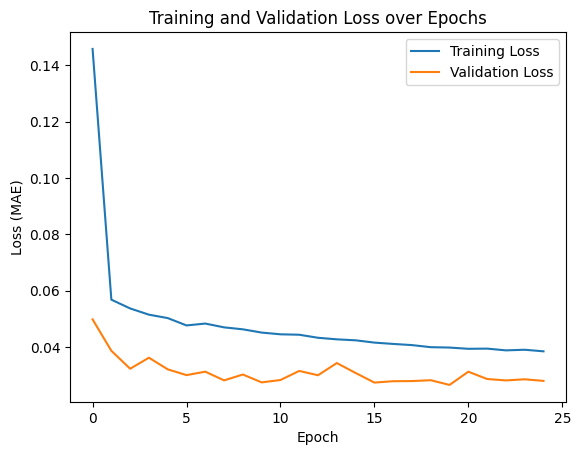

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 24)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733 (6.77 KB)

 Trainable params: 553 (2.16 KB)

 Non-trainable params: 72 (288.00 B)

 Optimizer params: 1,108 (4.33 KB)

In [26]:
model.evaluate(x_test_scaled, y_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0277 - mean_absolute_error: 0.0277


[0.027671102434396744, 0.027671102434396744]

In [27]:
preds = (model.predict(x_test_scaled))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [28]:
results_df = pd.DataFrame({'Actual Slip Ratio': y_test['slip_ratio'], 'Predicted Slip Ratio': preds.flatten()})
display(results_df)

,Actual Slip Ratio,Predicted Slip Ratio
43660,0.769808,0.739775
37278,0.135956,0.121456
14317,0.020556,0.012965
31932,0.064082,0.063886
45321,0.093175,0.092252
...,...,...
23441,0.486896,0.559807
1341,0.308708,0.225799
21987,0.196324,0.125451
26910,0.022300,0.044861


In [ ]:
results_df.describe()

,Actual Slip Ratio,Predicted Slip Ratio
count,20000.000000,20000.000000
mean,0.249076,0.239951
std,0.265360,0.267808
min,0.000007,-0.034518
25%,0.070871,0.069284
50%,0.142633,0.125914
75%,0.332429,0.296444
max,0.999647,1.007190



--- RUNNING PHYSICS VALIDATION ---
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Absolute Error: 0.02767


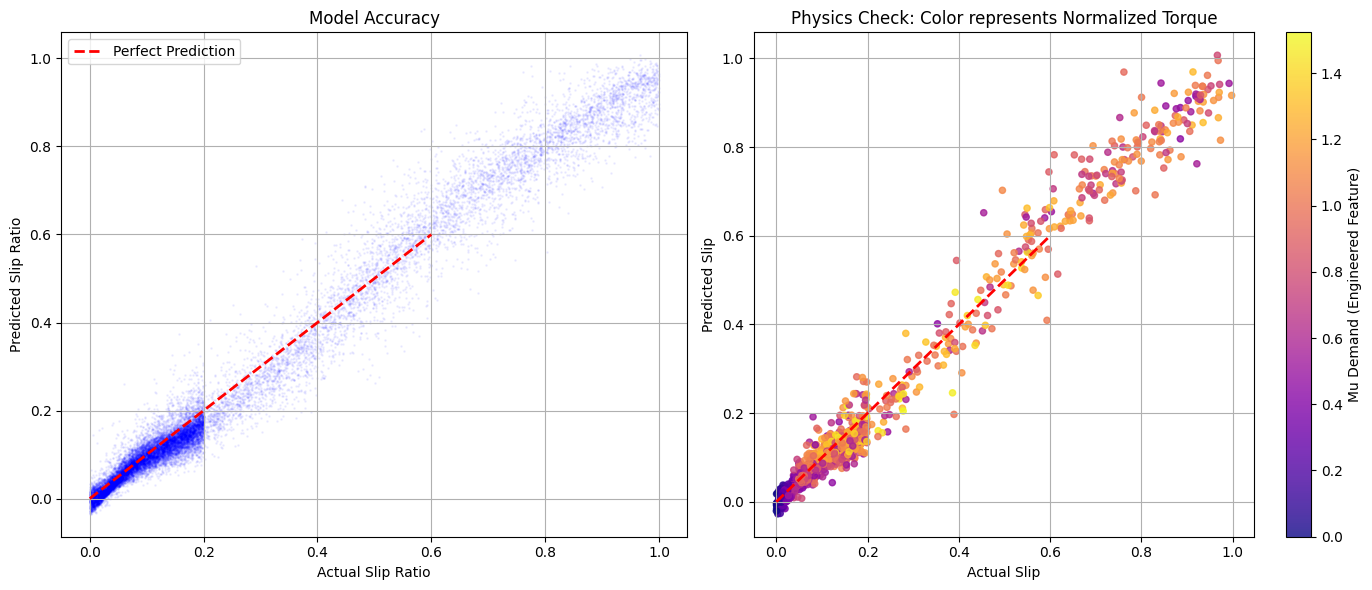

In [36]:
from sklearn.metrics import mean_absolute_error

print("\n--- RUNNING PHYSICS VALIDATION ---")
y_pred = model.predict(x_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.5f}")

plt.figure(figsize=(14, 6))

# Plot 1: The "Truth" Line
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.05, s=1, c='blue')
plt.plot([0, 0.6], [0, 0.6], 'r--', lw=2, label='Perfect Prediction')
plt.title("Model Accuracy")
plt.xlabel("Actual Slip Ratio")
plt.ylabel("Predicted Slip Ratio")
plt.legend()
plt.grid(True)

# Plot 2: Physics Awareness (Color = Torque)
# We want to see if the model understands that High Slip usually requires High Torque
# (Unless on ice/low friction)
plt.subplot(1, 2, 2)
# We sample 1000 points so the plot isn't too crowded
sample_indices = np.random.choice(len(y_test), 1000, replace=False)
y_sample = y_test.iloc[sample_indices]
pred_sample = y_pred[sample_indices]
mu_sample = x_test.iloc[sample_indices]['mu_demand']

sc = plt.scatter(y_sample, pred_sample, c=mu_sample, cmap='plasma', alpha=0.8, s=20)
plt.colorbar(sc, label='Mu Demand (Engineered Feature)')
plt.plot([0, 0.6], [0, 0.6], 'r--', lw=2)
plt.title("Physics Check: Color represents Normalized Torque")
plt.xlabel("Actual Slip")
plt.ylabel("Predicted Slip")
plt.grid(True)

plt.tight_layout()
plt.show()


In [37]:
model.save('slip_ratio_model.h5')
print("Model saved to slip_ratio_toy_model.h5")

Model saved to slip_ratio_toy_model.h5


In [38]:
model.save('slip_ratio_model.keras')
print("Model saved to slip_ratio_toy_model.keras")

Model saved to slip_ratio_toy_model.keras


In [39]:
import numpy as np

print("// --- COPY THESE INTO YOUR C++ CODE ---")
print("const float SCALER_MEAN[] = {")
for m in scaler.mean_:
    print(f"    {m:.6f}f,")
print("};")

print("\nconst float SCALER_SCALE[] = {")
for s in scaler.scale_:
    print(f"    {s:.6f}f,")
print("};")

// --- COPY THESE INTO YOUR C++ CODE ---
const float SCALER_MEAN[] = {
    20.030647f,
    123.299447f,
    0.880474f,
    2.056509f,
    60.171123f,
    -0.000566f,
};

const float SCALER_SCALE[] = {
    8.709296f,
    60.446279f,
    0.341923f,
    0.525582f,
    23.080191f,
    0.144138f,
};
